In [1]:
epochs, batch, lr = 100, 32, 1e-4
num_clients, in_channels, num_classes = 6, 1, 10
Dataset, Model, Prefix = 'MNIST', 'CNN_3', 'Attack'
Gdrive = '/content/drive/MyDrive/ColabNotebooks/SplitLearning3'
import torch; torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os; os.chdir(Gdrive)
%run library/Dataset.ipynb
%run library/Network.ipynb
%run library/Training.ipynb
from torchsummary import summary

In [4]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, SSIM

In [5]:
def reconstruct(decoders):
  image = next(iter(DataLoader(testset)))[0]
  plt.imshow(transforms.ToPILImage()(image[0]))
  plt.figure(figsize=(32,8))
  for i in range(num_clients):
    plt.subplot(1, num_clients, i+1)
    with torch.no_grad():
      network.clients[i].eval(), decoders[i].eval()
      output = decoders[i](network.clients[i](image.cuda()))
    plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
    plt.title('{}, {:.0e}'.format(ssim(image, output.cpu(), 1.0), F.mse_loss(image, output.cpu())))

#Fashion

In [6]:
dataset, testset = loadDataset('Fashion')

100%|██████████| 26421880/26421880 [00:02<00:00, 12561700.78it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209646.30it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3866493.75it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21442181.72it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [7]:
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())

In [8]:
class Decoder(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, 1, 1)
    )
  def forward(self, x):
    return self.model(x)

#DISCO

https://github.com/splitlearning/InferenceBenchmark

In [9]:
class Pruner(Module):
    def __init__(self, pruning_ratio):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(32, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, 1), nn.ReLU(),
            nn.Flatten(), nn.Linear(512, 32)
        )
        self.temp = 1/30
        self.pruning_ratio = pruning_ratio

    def prune_channels(self, z, indices=None):
        z.data[:, indices] = 0.
        return z

    def custom_sigmoid(self, x, offset):
        exponent = (x - offset) / self.temp
        return F.sigmoid(exponent)

    def get_channels_from_network(self, x, ratio):
        fmap_score = self.module(x)
        num_channels = x.shape[1]
        num_prunable_channels = int(num_channels * ratio)
        threshold_score = torch.sort(fmap_score)[0][:, num_prunable_channels].unsqueeze(1)
        return self.custom_sigmoid(fmap_score, threshold_score)

    def forward(self, x):
        # get score for feature maps
        channel_score = self.get_channels_from_network(x, self.pruning_ratio)
        index_array = torch.arange(x.shape[1]).repeat(x.shape[0], 1).cuda()
        return self.prune_channels(x, index_array[channel_score < 0.5])
        return x * channel_score.unsqueeze(-1).unsqueeze(-1)

In [10]:
def train_network(self, epoch, pruning_ratio):
    local = lambda m, p: m.client[0] if p else m
    self.server.train()
    models = (self.clients[-1].state_dict(), self.clients[-1].pruner.state_dict())
    for idx, client in enumerate(self.clients):
        client.load_state_dict(models[0]), client.pruner.load_state_dict(models[1])
        client.train(), client.pruner.train(), client.decoder.train()
        for images, labels in client.loader:
            client.zero_grad(), self.server.zero_grad()
            client.pruner.zero_grad(), client.decoder.zero_grad()

            unpruned_z_out = client(images)
            unpruned_z_in = unpruned_z_out.detach().requires_grad_(True)
            pruned_z_out = client.pruner(unpruned_z_in)

            pruned_z_in = pruned_z_out.detach().requires_grad_(True)
            x_recons = client.decoder(pruned_z_in)
            adv_loss = F.mse_loss(x_recons, images)

            output = self.server(pruned_z_out.detach().requires_grad_(True))
            obj_loss = F.cross_entropy(output, labels)
            server_grads = self.server.backward(obj_loss)

            adv_loss.backward() #pruned_z_in
            client.decoder.optimizer.step()

            pruned_z_out.backward(server_grads, retain_graph=True)
            client.backward(unpruned_z_in.grad)
            client.optim_step()

            for params in client.pruner.parameters():
                if params.grad: params.grad *= (1 - 0.5)
            pruned_z_out.backward(-1 * 0.5 * pruned_z_in.grad)
            client.pruner.optimizer.step()

            self.server.optim_step()
        client.sched_step(), client.pruner.scheduler.step(), client.decoder.scheduler.step()
        models = (client.state_dict(), client.pruner.state_dict())
    self.server.sched_step()

def evaluate(self):
    with torch.no_grad():
      self.server.eval()
      for client in self.clients:
        client.eval(), client.pruner.eval()
        client.accuracy.append(0)
        for images, labels in self.server.loader:
          output = self.server(client.pruner(client(images))).argmax(1)
          client.accuracy[-1] += (output == labels).sum().item()
        client.accuracy[-1] /= len(self.server.loader.dataset)

def train_splitnn(clients, testset, method, epochs=epochs, model=Model, pruning_ratio=0):
    in_channels, num_classes, tester = loadTester(testset)
    models = [globals()[model](in_channels, num_classes) for c in clients]
    model = SplitNN([Client(m.client) for m in models], Server(models[0].server))
    model.initialize(clients, tester, epochs, batch, lr)
    for client in model.clients:
        client.pruner = Pruner(pruning_ratio).cuda()
        client.pruner.optimizer = optim.Adam(client.pruner.parameters(), lr)
        client.pruner.scheduler = optim.lr_scheduler.CosineAnnealingLR(client.pruner.optimizer, epochs)
        client.decoder = Decoder().cuda()
        client.decoder.optimizer = optim.Adam(client.decoder.parameters(), lr)
        client.decoder.optimizer = optim.lr_scheduler.CosineAnnealingLR(client.decoder.optimizer, epochs)

    for client in model.clients:
        client.decoder = Decoder().cuda()
        client.decoder.optimizer = optim.Adam(client.decoder.parameters(), lr)
        client.decoder.scheduler = optim.lr_scheduler.CosineAnnealingLR(client.decoder.optimizer, epochs)

    for epoch in tqdm(range(epochs)):
        train_network(model, epoch, pruning_ratio)
        evaluate(model)
        plot_progress(model.clients, locals())
    return model

In [13]:
class VGG_7_DISCO(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DISCO', .6)
for client in network.clients: client.client.append(client.pruner)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

In [14]:
class Decoder2(Autodecoder):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.LeakyReLU(.2),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            #nn.Conv2d(16, 16, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            nn.ConvTranspose2d(16, 1, 3, 1, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

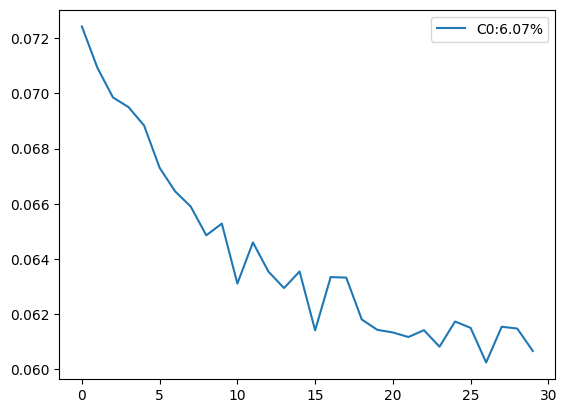

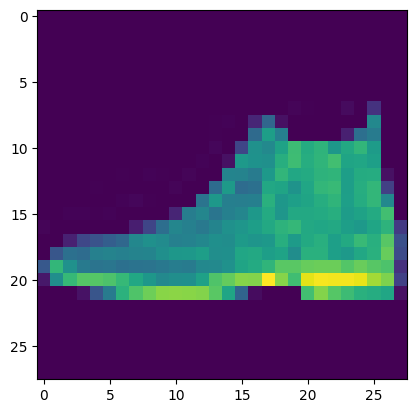

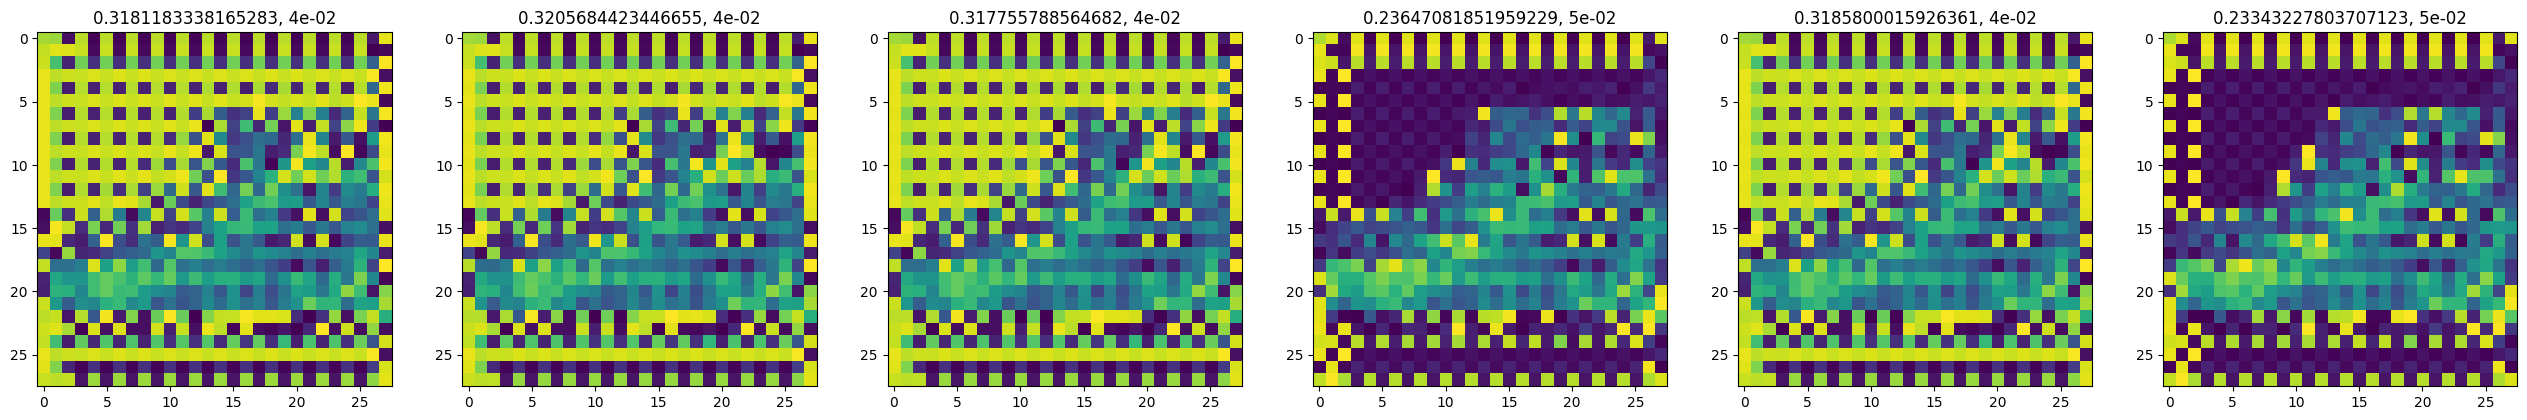

In [15]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

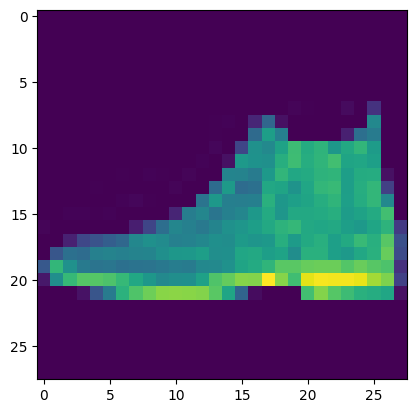

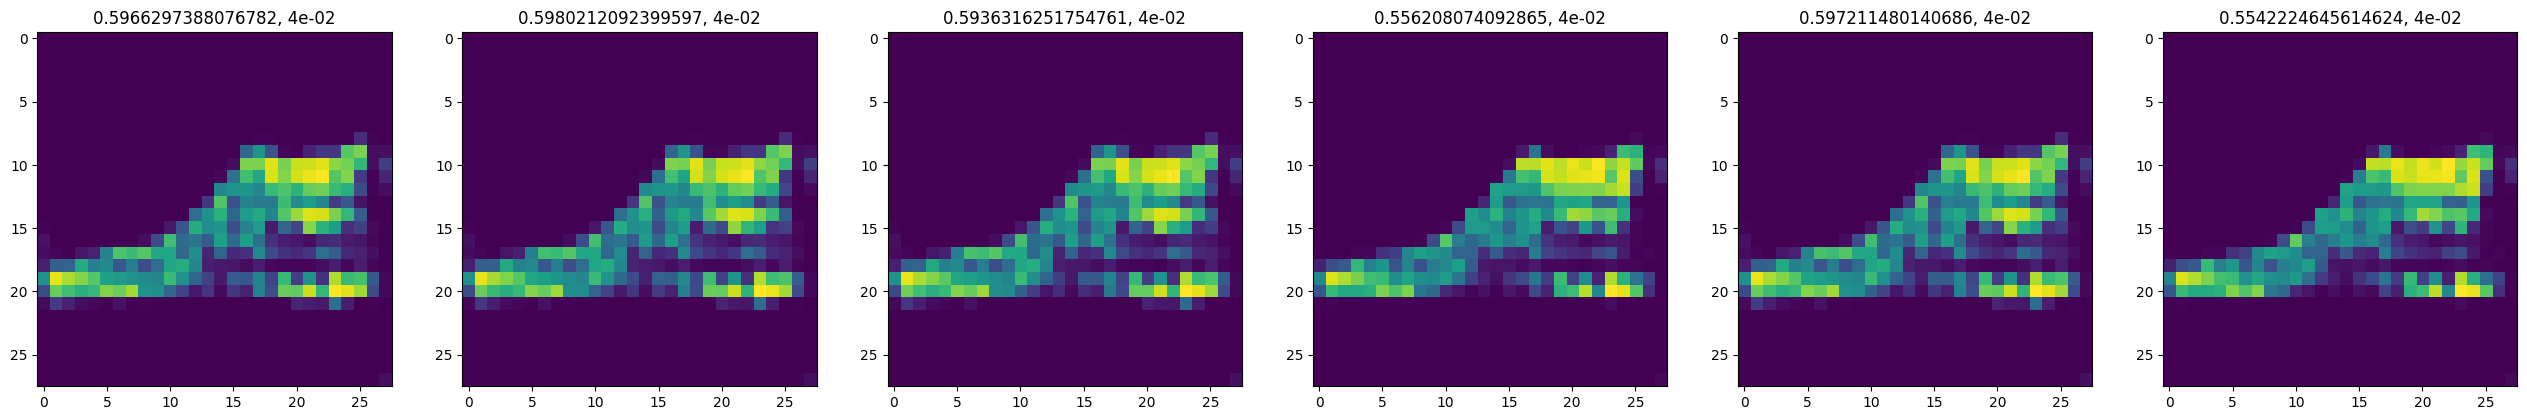

In [16]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [17]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DISCO', .5)
for client in network.clients: client.client.append(client.pruner)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

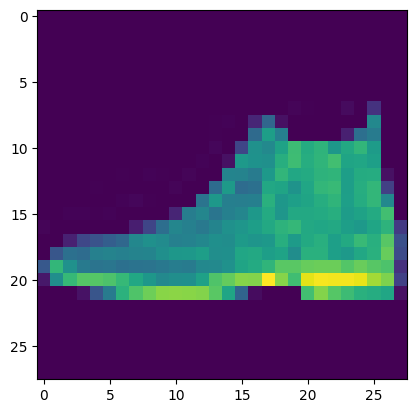

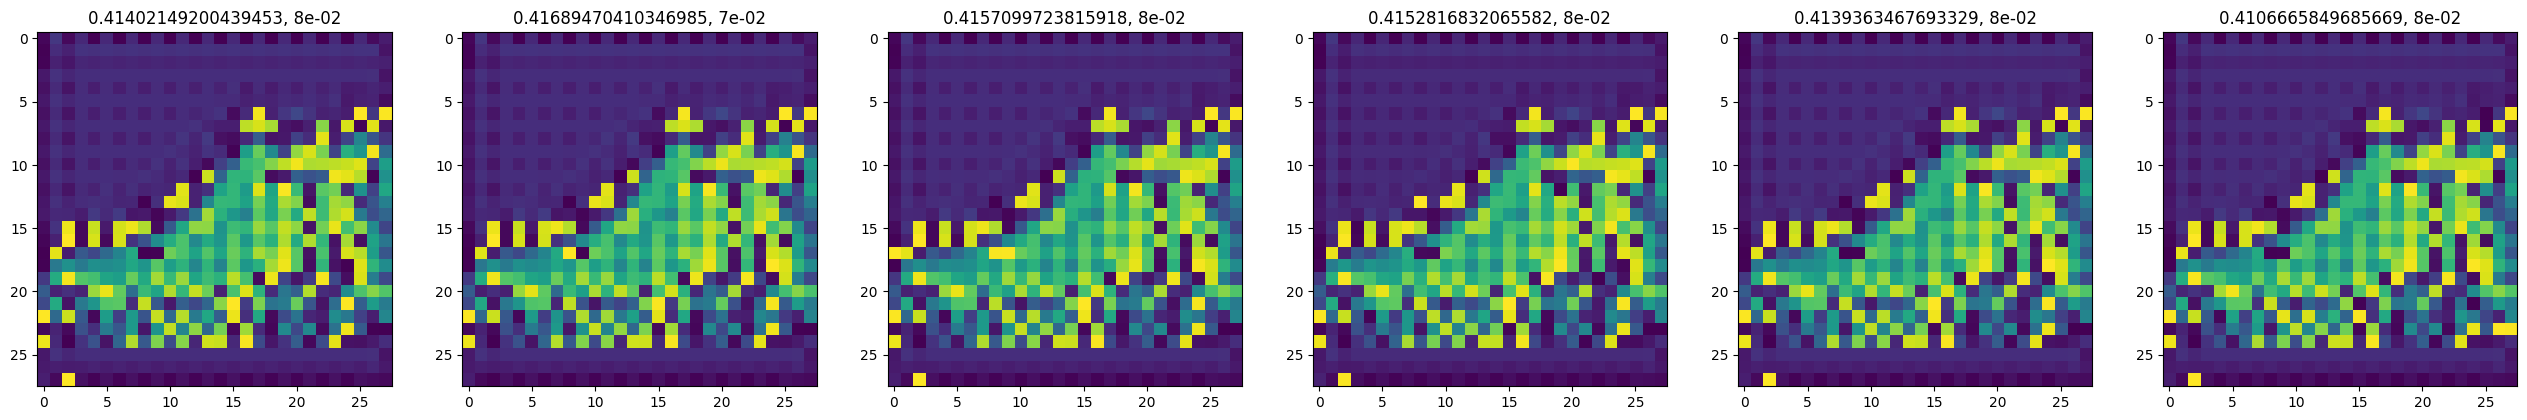

In [18]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

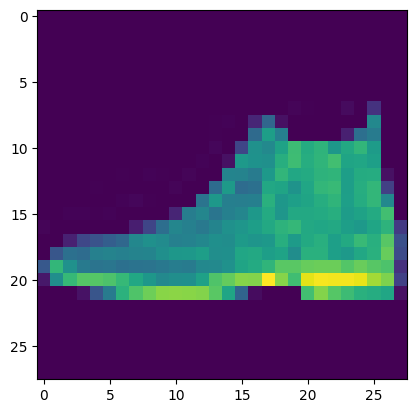

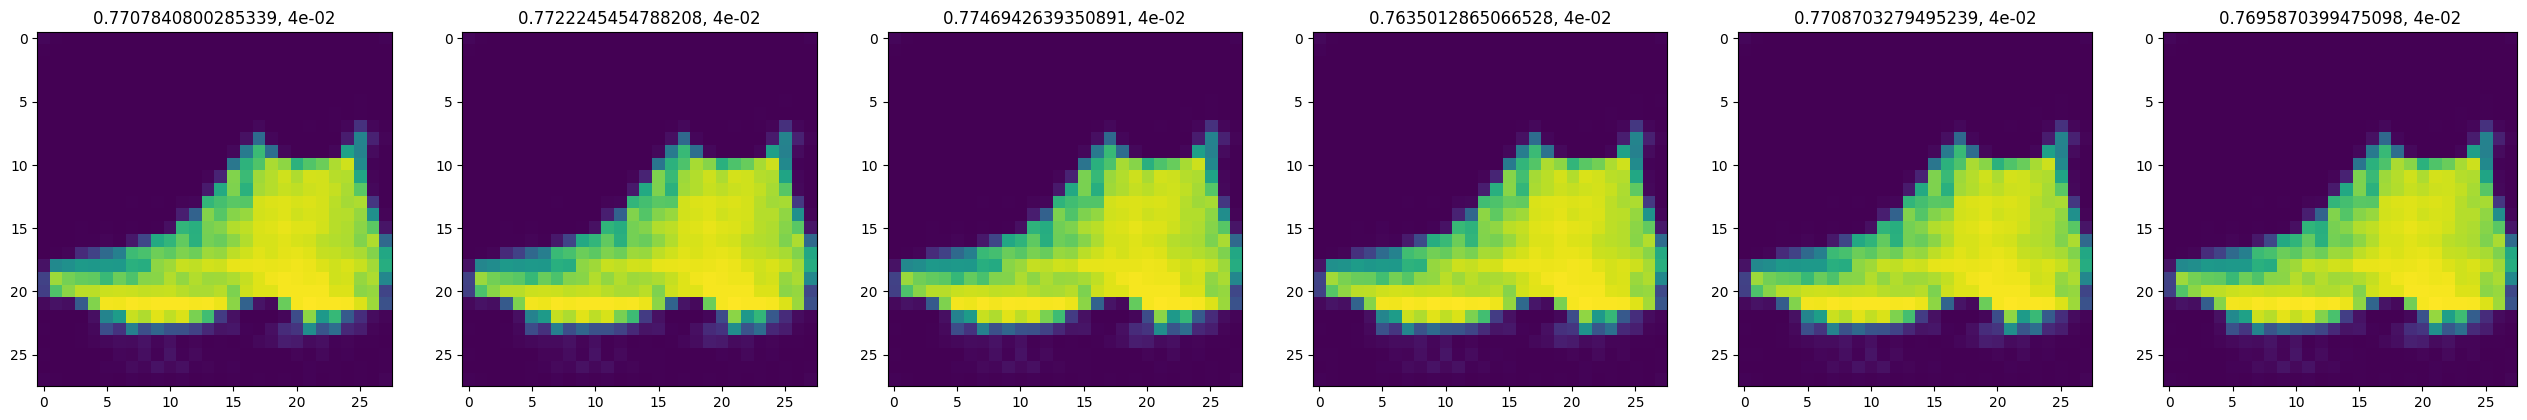

In [19]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [21]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DISCO', .4)
for client in network.clients: client.client.append(client.pruner)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

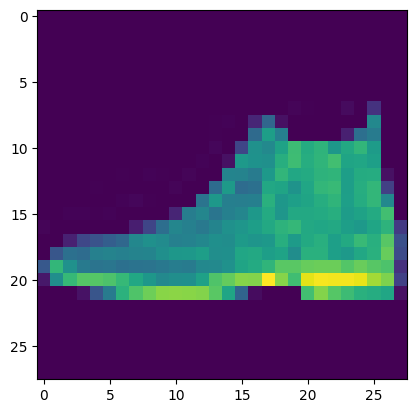

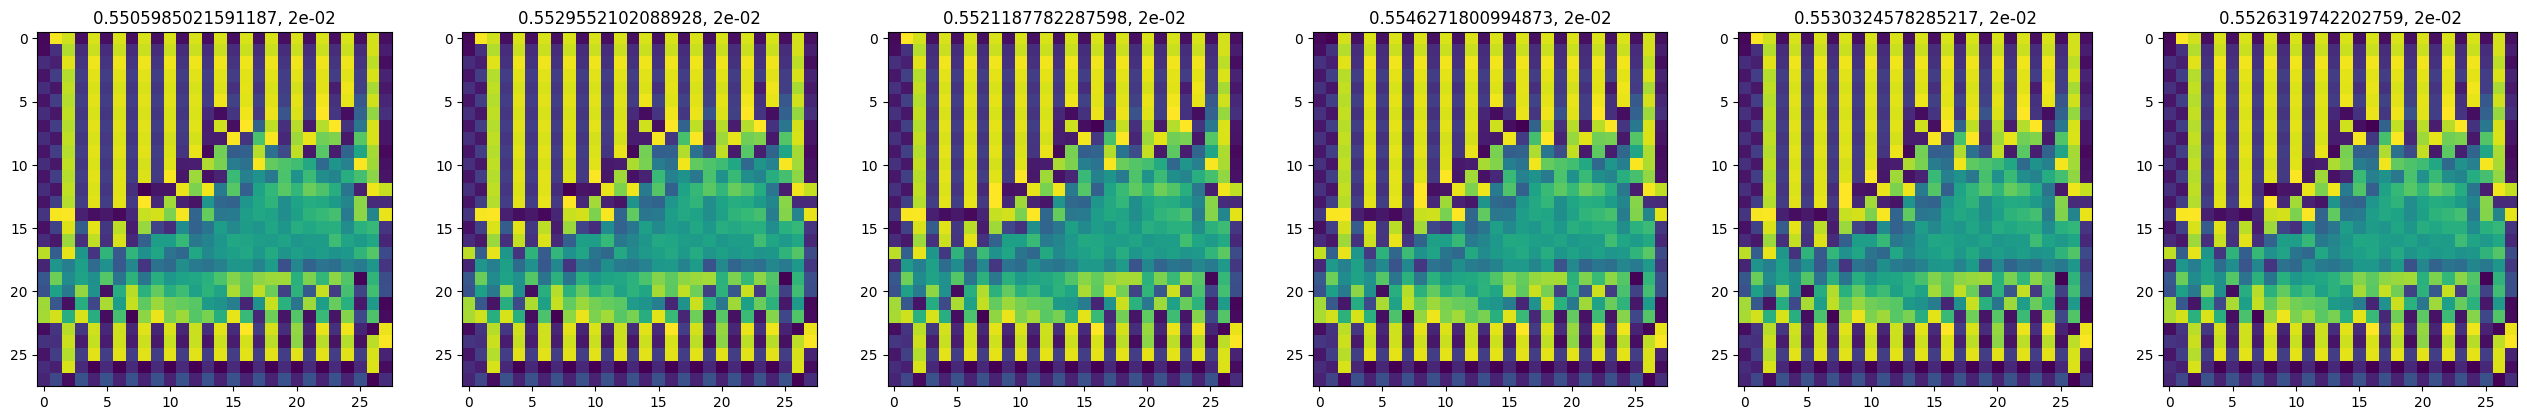

In [22]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

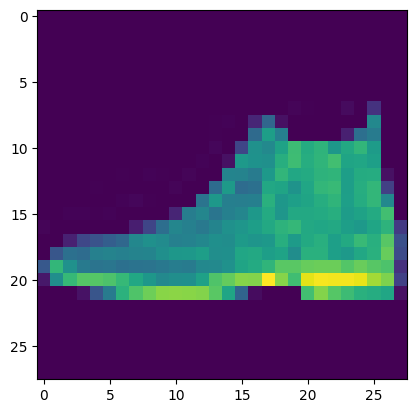

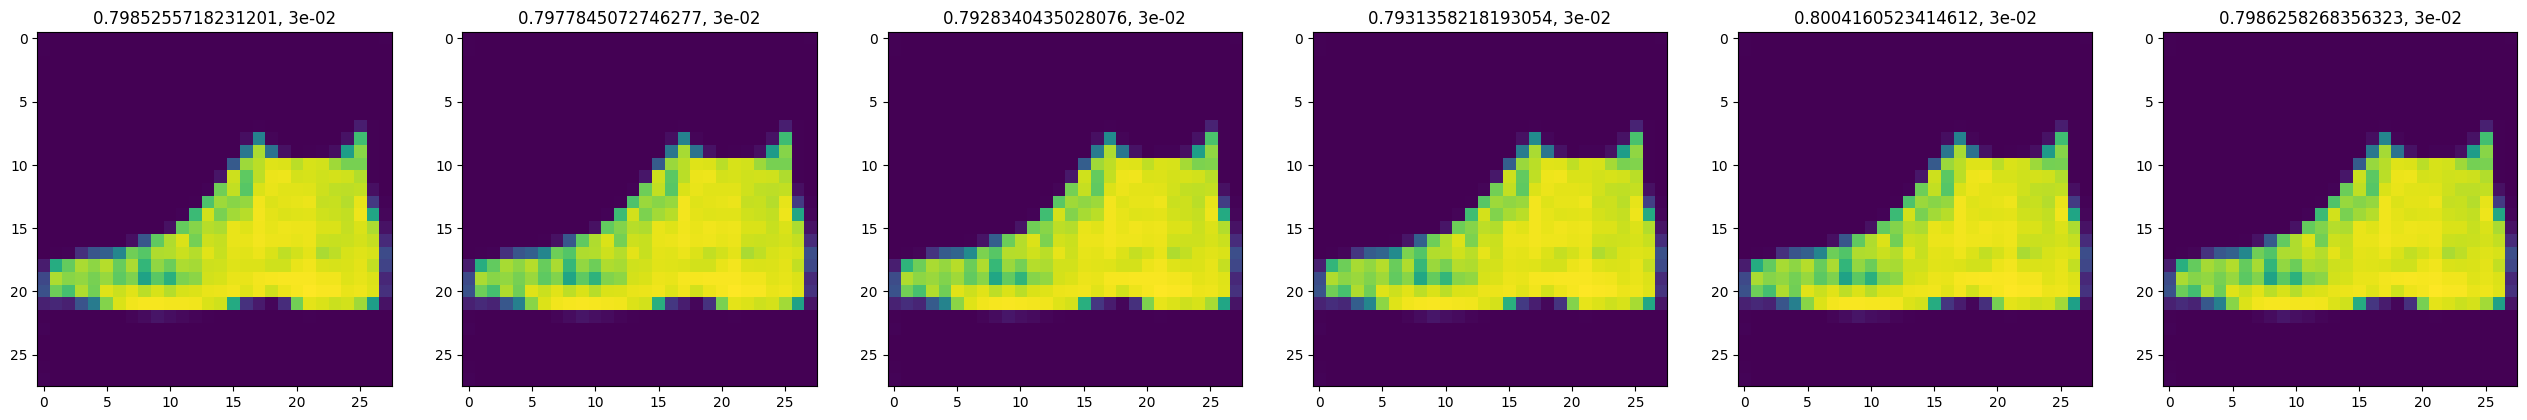

In [23]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [24]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DISCO', .3)
for client in network.clients: client.client.append(client.pruner)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

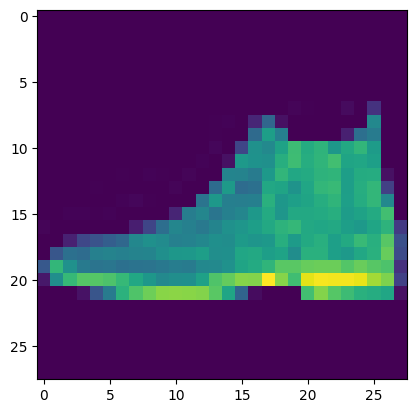

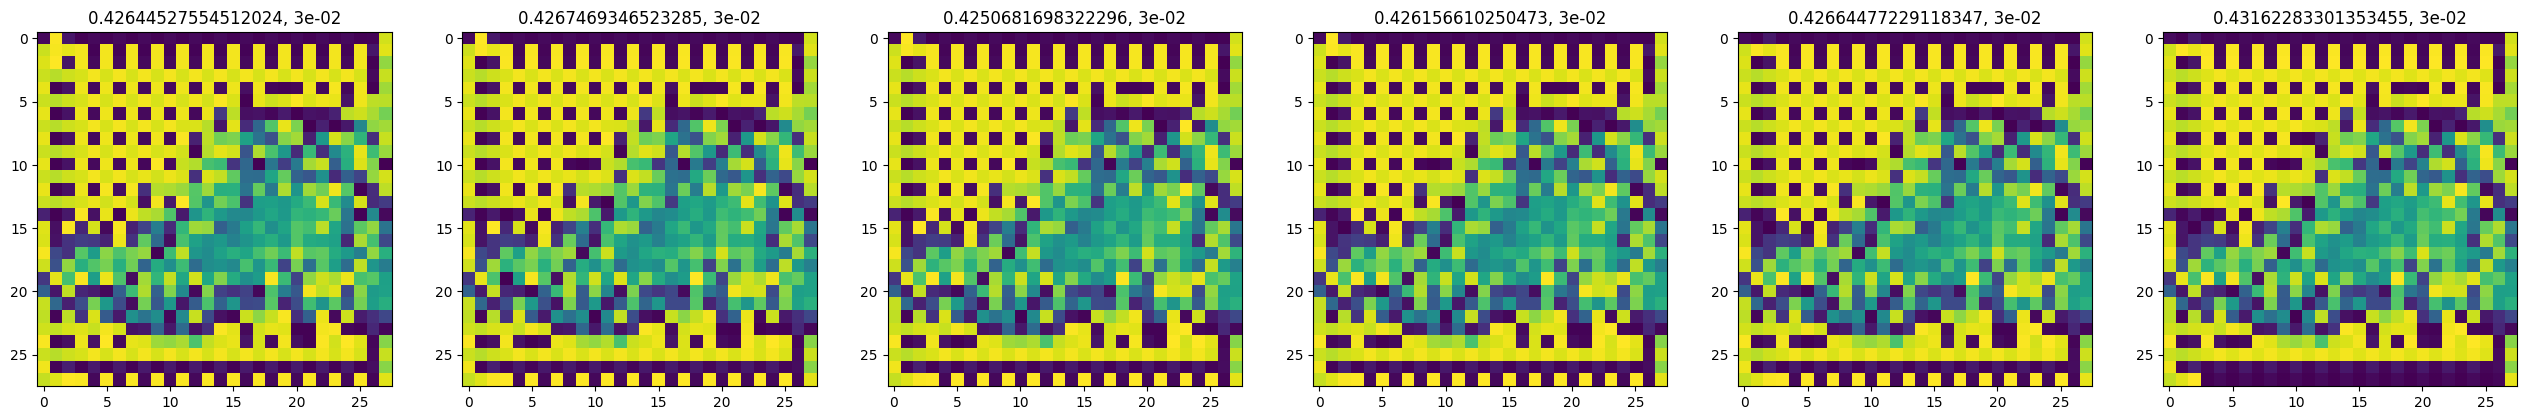

In [25]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

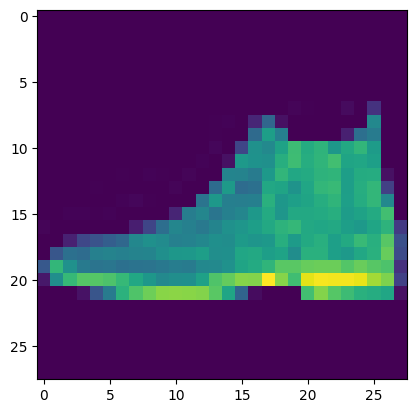

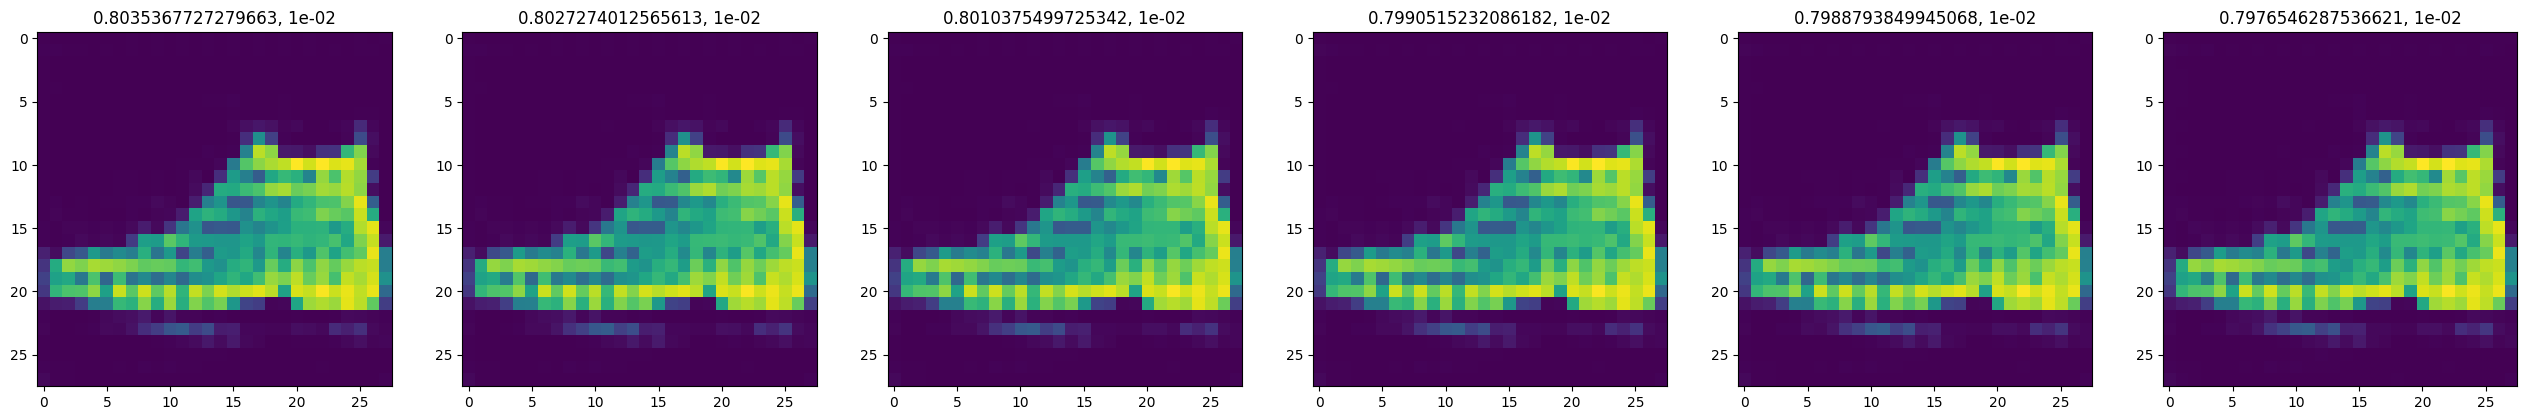

In [26]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [27]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DISCO', .2)
for client in network.clients: client.client.append(client.pruner)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

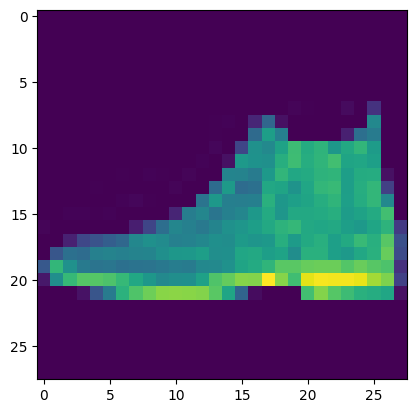

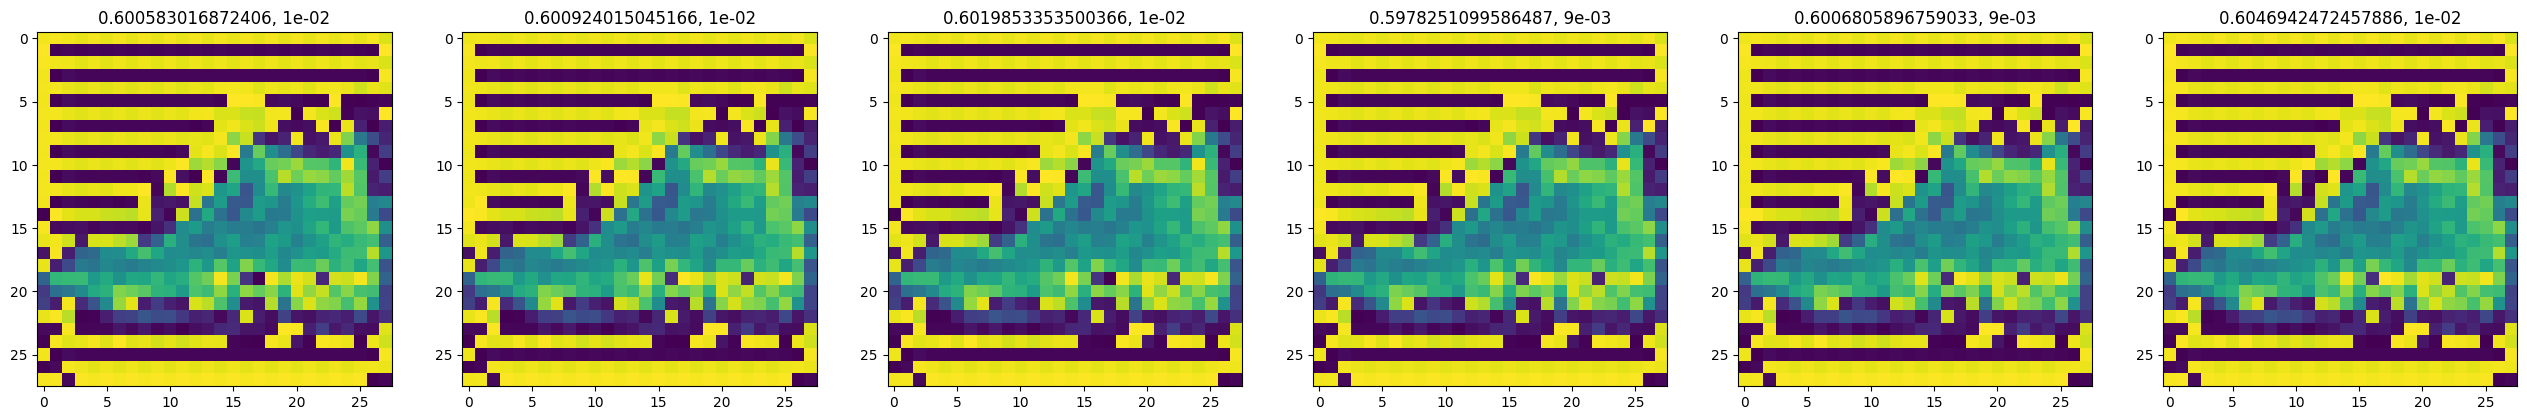

In [28]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

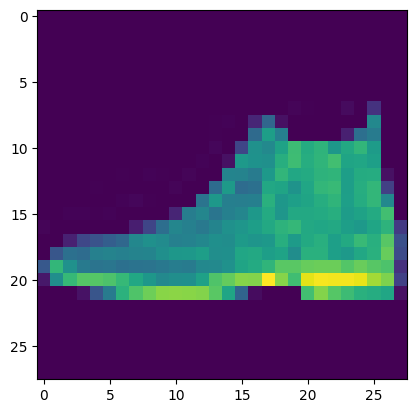

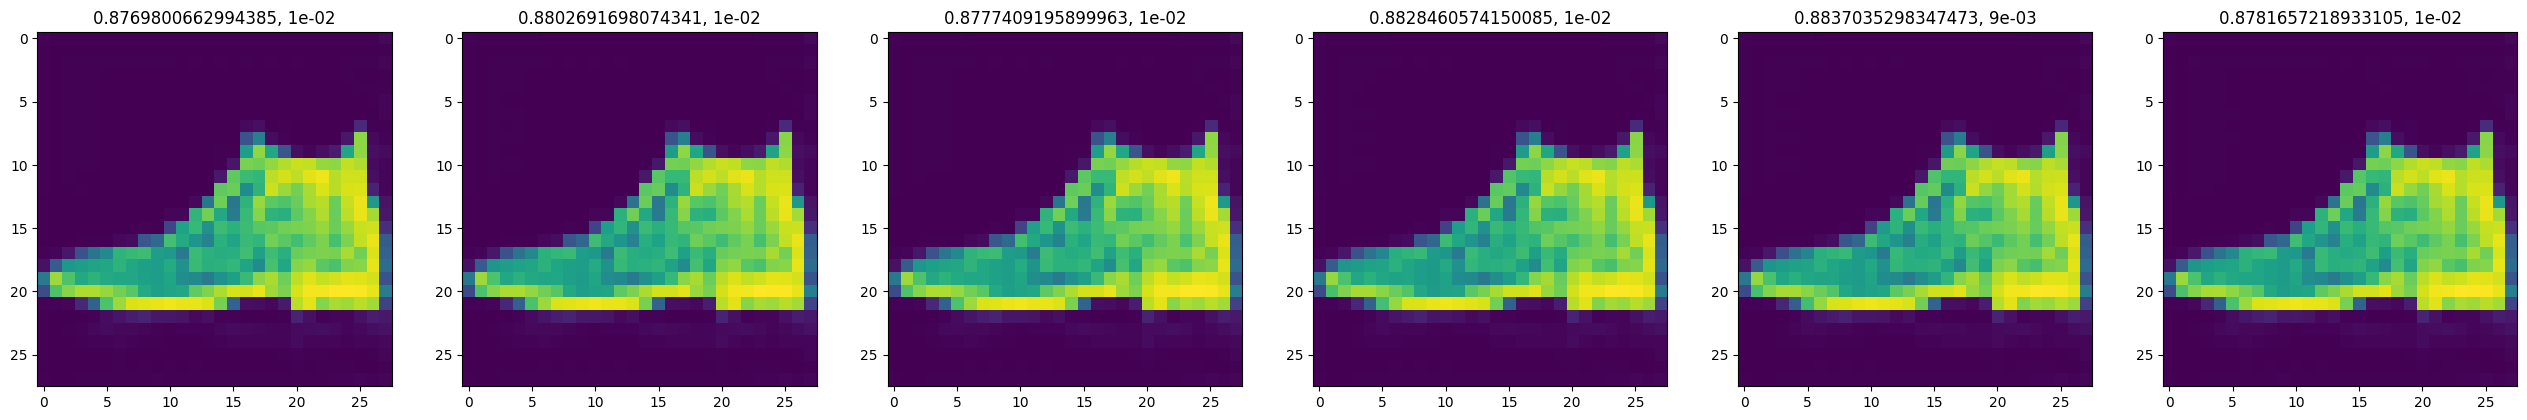

In [29]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [30]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DISCO', .1)
for client in network.clients: client.client.append(client.pruner)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

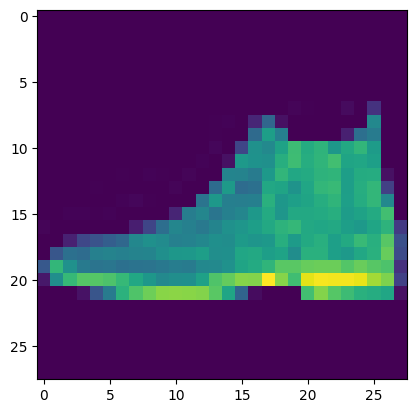

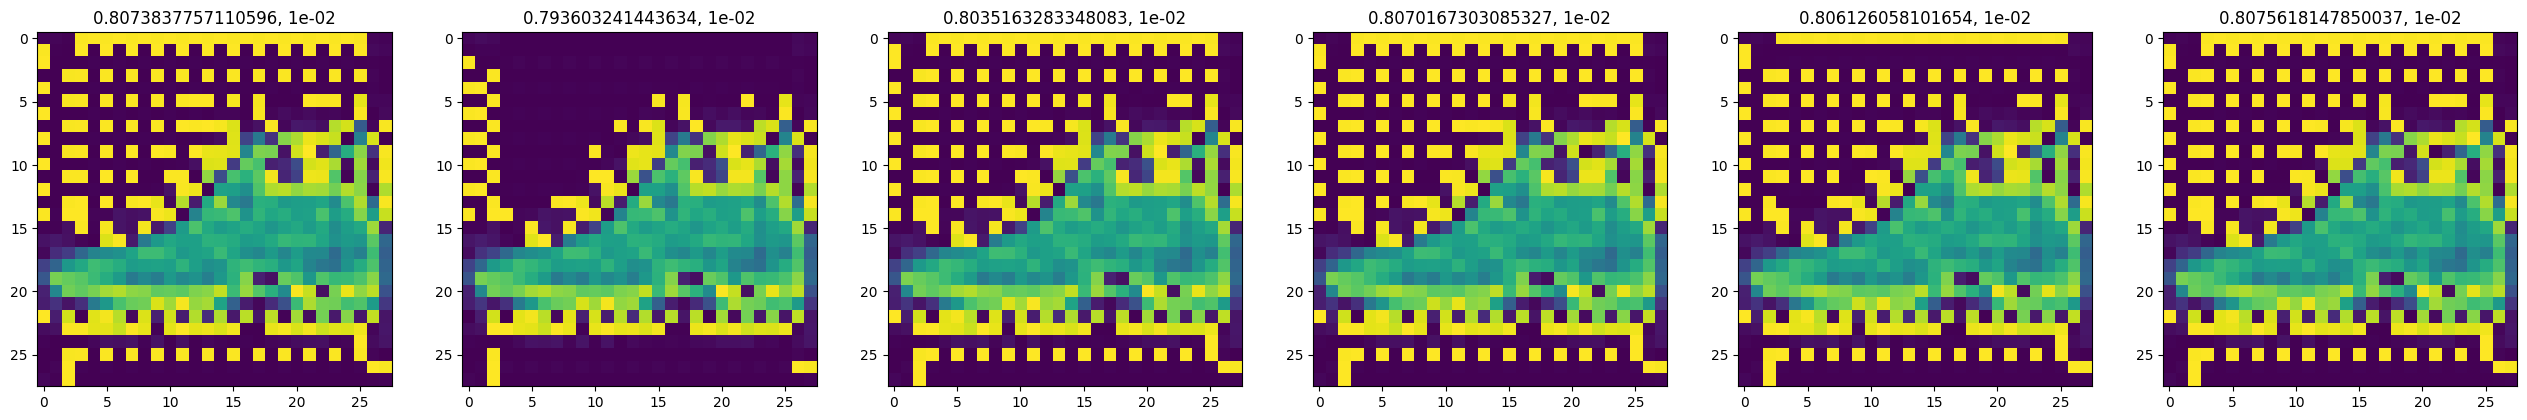

In [31]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

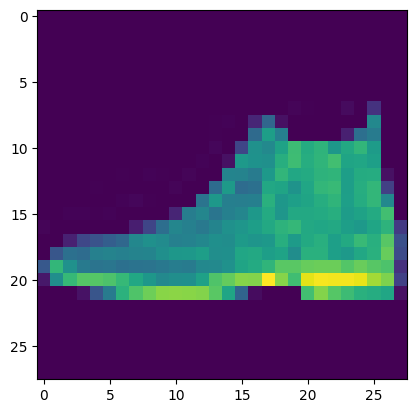

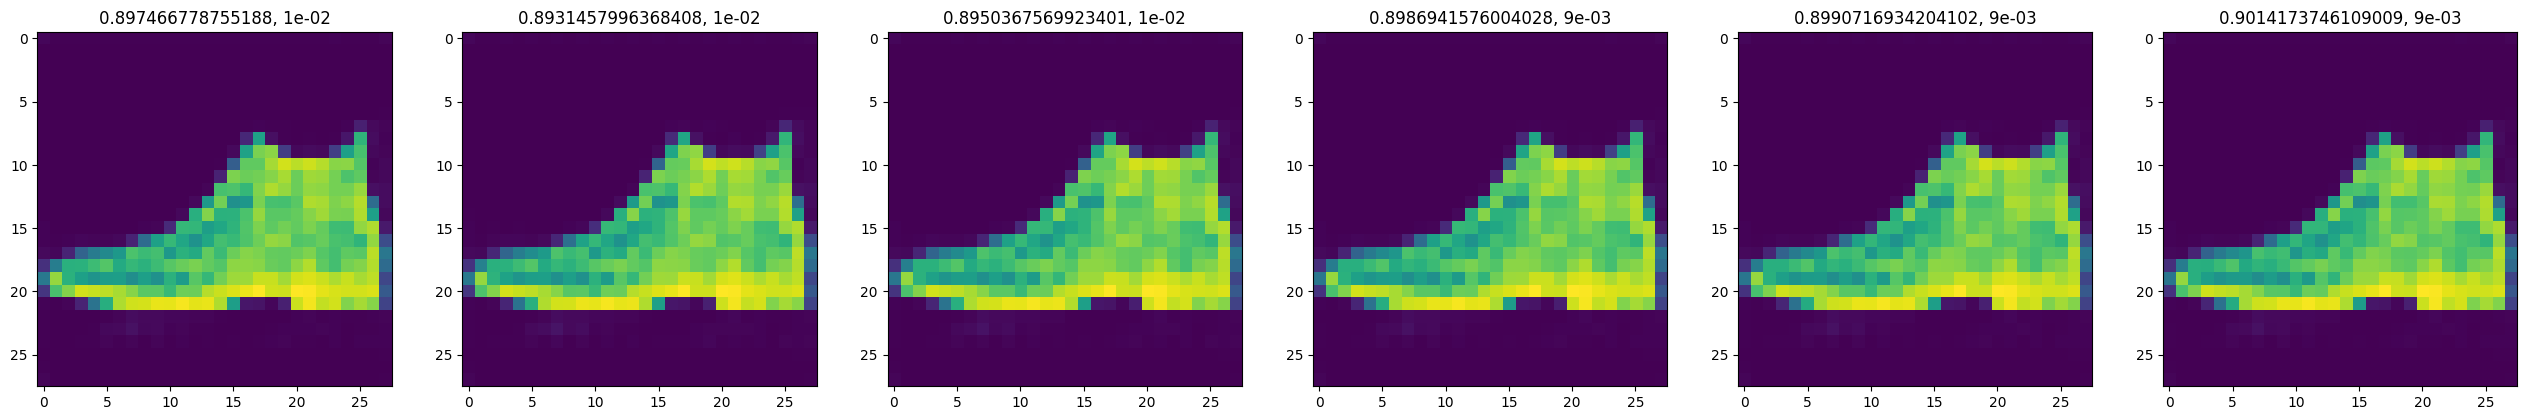

In [32]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [33]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DISCO', .0)
for client in network.clients: client.client.append(client.pruner)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

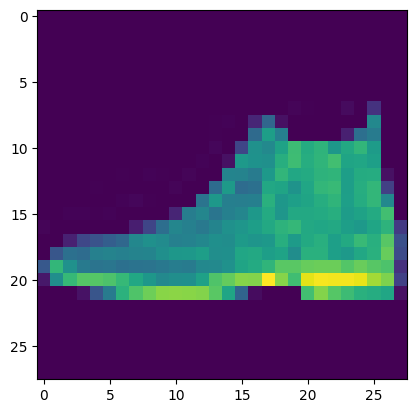

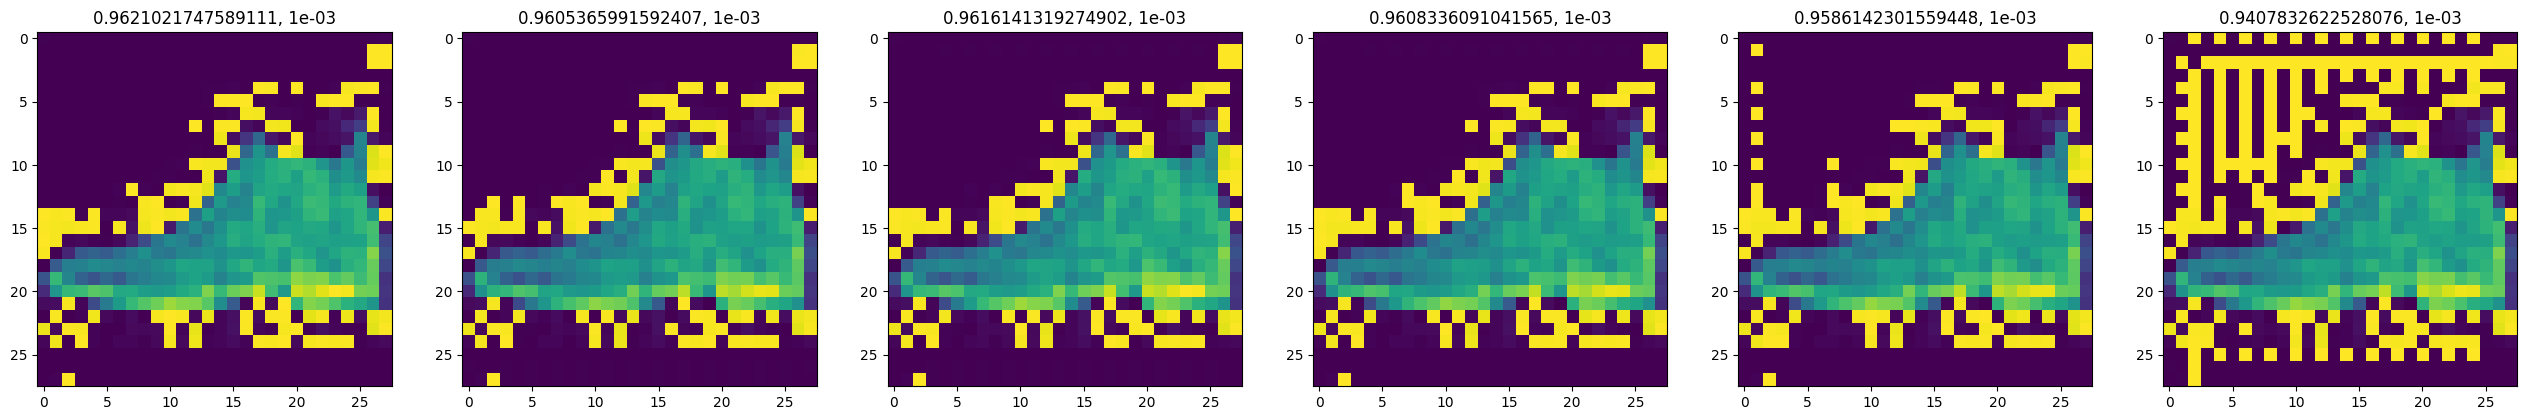

In [34]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

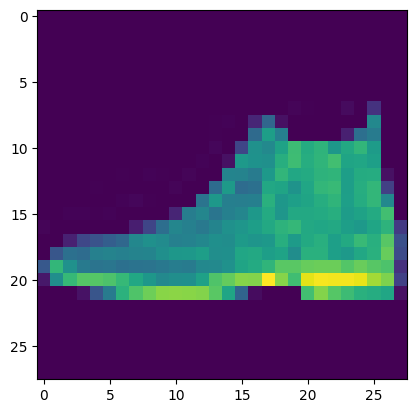

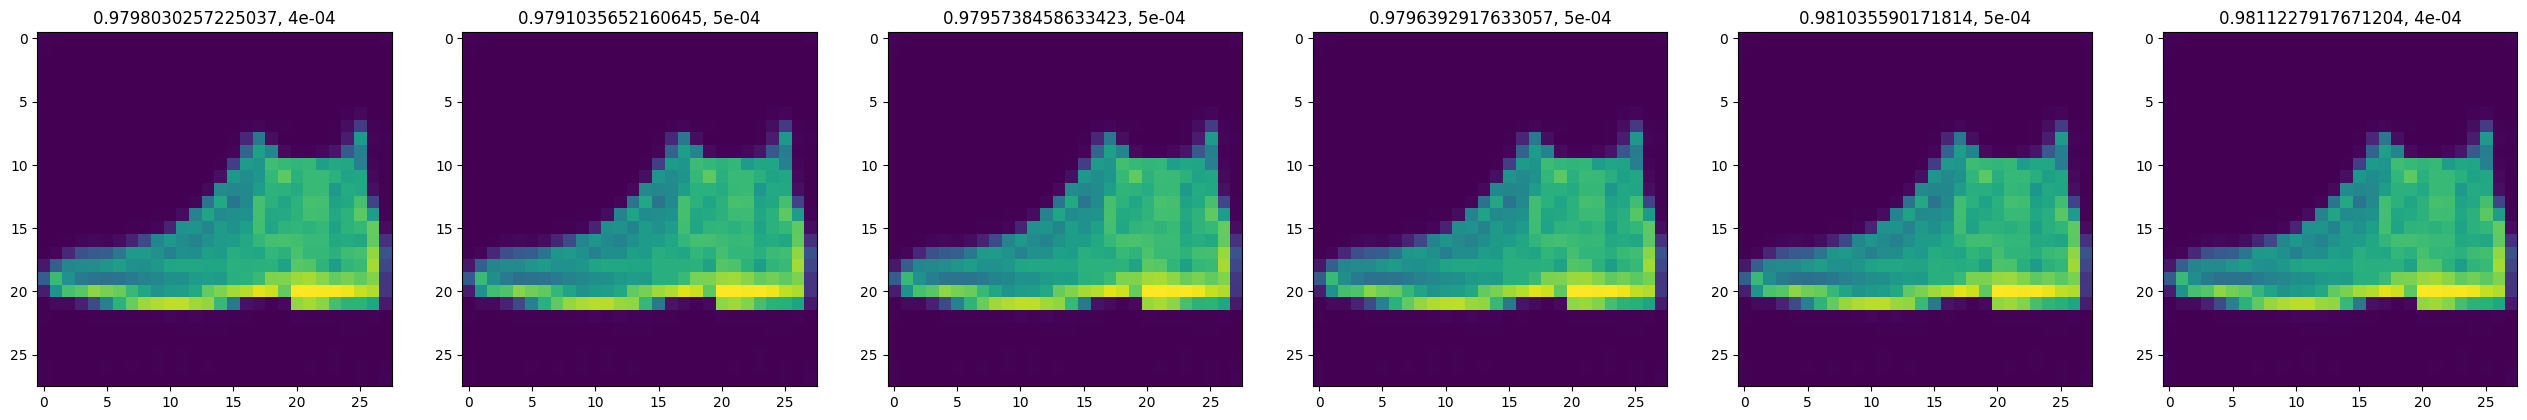

In [35]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])